In [1]:
import os
import pandas as pd

### 미세먼지 수치가 중국 지수의 선행 지표가 될 수 있는지 검증해보자

In [2]:
# 서울시 기간별 일평균 대기환경 정보
# https://data.seoul.go.kr/dataList/OA-2220/F/1/datasetView.do
def read_data(path, encoding='euc-kr'):
    if path.endswith('xlsx'):
        df = pd.read_excel(path, encoding=encoding)
    else: # csv
        df = pd.read_csv(path, encoding=encoding)
    df['측정일자'] = df['측정일자'].apply(lambda x: pd.to_datetime(str(x)))
    return df
    
def aggregate_by_date(df):
    df = df[['측정일자', '미세먼지(㎍/㎥)']]
    df = df.groupby('측정일자').agg('mean')
    return df

In [3]:
fine_dust_data = []

for path in os.listdir('./'):
    if path.startswith('기간별_일평균_대기환경_정보'):
        df = read_data(path)
        df = aggregate_by_date(df)
        fine_dust_data.append(df)
        
fine_dust_data = pd.concat(fine_dust_data, axis=0, sort=True).sort_index()

In [4]:
fine_dust_data.head()

,미세먼지(㎍/㎥)
측정일자,
2015-01-01,66.40
2015-01-02,29.04
2015-01-03,36.72
2015-01-04,42.16
2015-01-05,76.24


In [5]:
import FinanceDataReader as fdr

kospi = fdr.DataReader('KS11', '2015-01-01', '2018-12-31') # 코스피
csi300 = fdr.DataReader('CSI300', '2015-01-01', '2018-12-31') # 중국 CSI300

In [6]:
kospi.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2015-01-02,1926.44,1914.24,1929.15,1909.67,258780000.0,0.0057
2015-01-05,1915.75,1921.96,1921.96,1903.37,313440000.0,-0.0055
2015-01-06,1882.45,1895.48,1900.02,1877.38,303690000.0,-0.0174
2015-01-07,1883.83,1878.90,1887.60,1876.27,280510000.0,0.0007
2015-01-08,1904.65,1895.85,1907.23,1891.77,262210000.0,0.0111


In [7]:
csi300.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2015-01-05,3641.54,3566.09,3669.04,3551.51,451200.0,0.0305
2015-01-06,3641.06,3608.43,3683.23,3587.23,420960.0,-0.0001
2015-01-07,3643.79,3620.92,3671.19,3601.70,320190.0,0.0007
2015-01-08,3559.26,3650.07,3659.95,3552.10,295000.0,-0.0232
2015-01-09,3546.72,3547.57,3689.75,3536.39,349980.0,-0.0035


In [8]:
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

/Users/wook/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


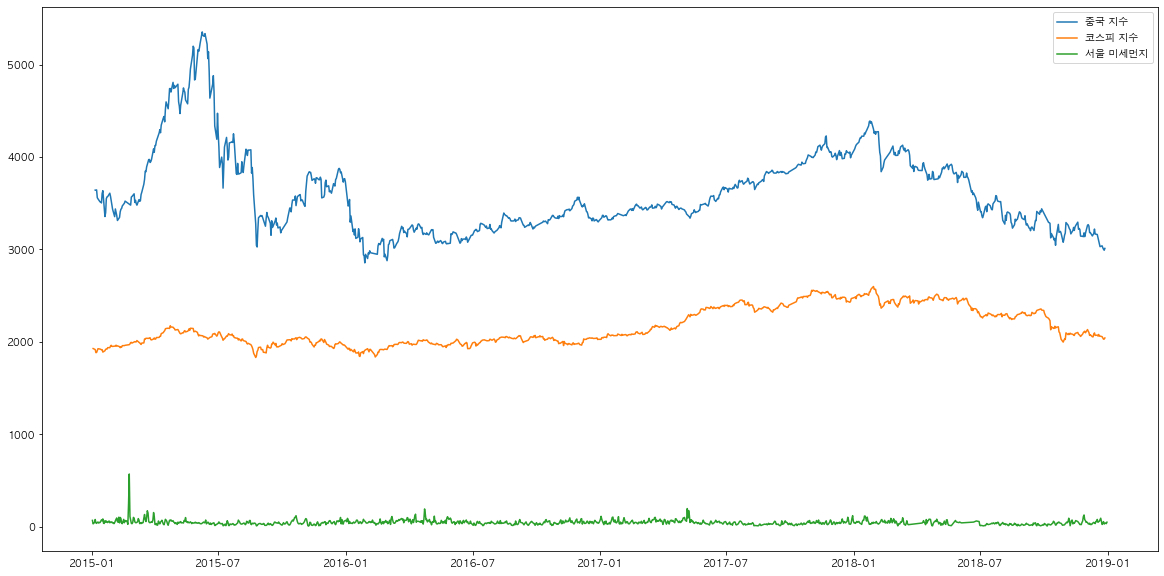

In [9]:
plt.figure(figsize=(20,10))
plt.plot(csi300['Close'], label='중국 지수')
plt.plot(kospi['Close'], label='코스피 지수')
plt.plot(fine_dust_data['미세먼지(㎍/㎥)'], label='서울 미세먼지')
plt.legend(loc='upper right')

### 스케일이 달라 비교하기 힘드니 스케일링 해주자

In [10]:
def min_max_scale(column):
    # 0 이상 1 이하 값으로 스케일링
    _min = column.min()
    _max = column.max()
    column = column.apply(lambda x: (x - _min) / (_max - _min))
    return column

In [11]:
min_max_scale(csi300['Close']).head()

Date
2015-01-05    0.315113
2015-01-06    0.314921
2015-01-07    0.316013
2015-01-08    0.282201
2015-01-09    0.277185
Name: Close, dtype: float64

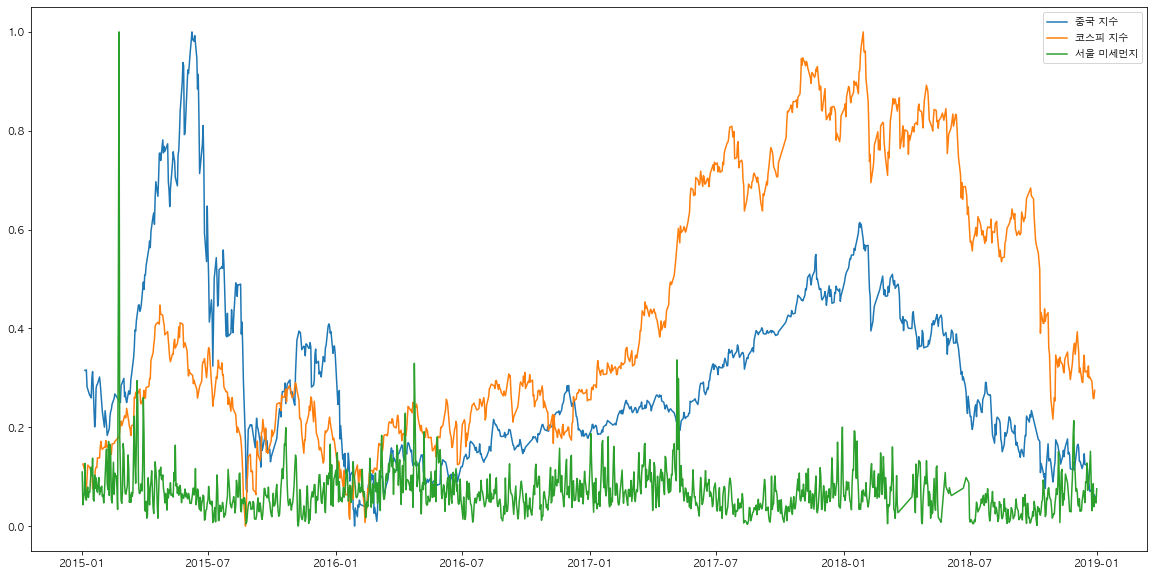

In [12]:
plt.figure(figsize=(20,10))
plt.plot(min_max_scale(csi300['Close']), label='중국 지수')
plt.plot(min_max_scale(kospi['Close']), label='코스피 지수')
plt.plot(min_max_scale(fine_dust_data['미세먼지(㎍/㎥)']), label='서울 미세먼지')
plt.legend(loc='upper right')

### 미세먼지가 peak를 찍는 부분을 표시해보자

In [13]:
# 미세먼지 peak: 30일 이동평균을 3시그마 이상 벗어난 것으로 정의

window_size = 30 # 이동평균/표준편차 구할 기간(단위: 일)
fine_dust_data['이동평균'] = fine_dust_data['미세먼지(㎍/㎥)'].rolling(window=window_size).mean()
fine_dust_data['이동표준편차'] = fine_dust_data['미세먼지(㎍/㎥)'].rolling(window=window_size).std()

In [14]:
fine_dust_data.tail()

,미세먼지(㎍/㎥),이동평균,이동표준편차
측정일자,,,
2018-12-27,26.68,48.132000,22.966961
2018-12-28,34.92,45.129333,17.900438
2018-12-29,38.32,43.942667,17.087567
2018-12-30,31.00,42.830667,16.796051
2018-12-31,47.24,42.920000,16.812685


In [15]:
# 최근 경향보다 값이 크고 & 3시그마 이상 이탈하면 peak
fine_dust_data['미세먼지_급증'] = (fine_dust_data['미세먼지(㎍/㎥)'] > fine_dust_data['이동평균']) & \
                                ((fine_dust_data['미세먼지(㎍/㎥)']  - fine_dust_data['이동평균']) / fine_dust_data['이동표준편차'] >= 3)

In [16]:
fine_dust_peak_dates = fine_dust_data.loc[fine_dust_data['미세먼지_급증'] == True].index

In [17]:
fine_dust_peak_dates

DatetimeIndex(['2015-02-22', '2015-02-23', '2015-10-19', '2015-12-24',
               '2016-04-23', '2017-01-02', '2017-03-12', '2017-05-06',
               '2017-09-09', '2017-12-23', '2017-12-30', '2018-11-06'],
              dtype='datetime64[ns]', name='측정일자', freq=None)

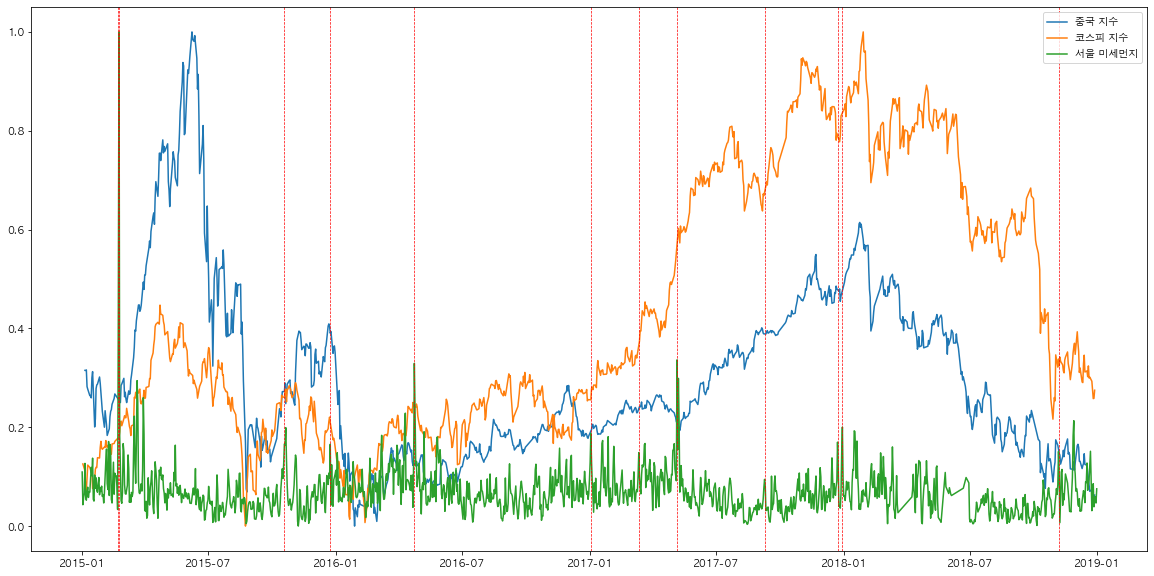

In [18]:
plt.figure(figsize=(20,10))
plt.plot(min_max_scale(csi300['Close']), label='중국 지수')
plt.plot(min_max_scale(kospi['Close']), label='코스피 지수')
plt.plot(min_max_scale(fine_dust_data['미세먼지(㎍/㎥)']), label='서울 미세먼지')
for date in fine_dust_peak_dates:
    plt.axvline(date, color='r', linestyle='--', lw=0.7)
plt.legend(loc='upper right')

### peak 시점 이후에 몇달 정도 지수가 증가하는 경향이 있음 (15년 말에 하락하는 케이스 1건 제외)